Looking at crypto orderbooks has been an intriguing for me. Yet I haven't the opportunity to dug into it other than starting at the exchanges. Thanks to the [crypto-lake.com](https://crypto-lake.com/)'s sample/free market data I have a source to dig into it. Fully aware that zooming in I might take in microstructure noise as well, so I have to be careful. Let's dig in.

In [ ]:
# Comment if not running in Colab
!pip install lakeapi -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 248 kB 8.0 MB/s 
     |████████████████████████████████| 132 kB 64.7 MB/s 
     |████████████████████████████████| 112 kB 49.8 MB/s 
     |████████████████████████████████| 26.7 MB 1.7 MB/s 
     |████████████████████████████████| 43 kB 1.2 MB/s 
     |████████████████████████████████| 51 kB 38 kB/s 
     |████████████████████████████████| 207 kB 60.3 MB/s 
     |████████████████████████████████| 73 kB 871 kB/s 
     |████████████████████████████████| 10.2 MB 40.1 MB/s 
     |████████████████████████████████| 79 kB 5.8 MB/s 
     |████████████████████████████████| 140 kB 51.9 MB/s 
     |████████████████████████████████| 41 kB 417 kB/s 
     |████████████████████████████████| 131 kB 55.4 MB/s 
     |████████████████████████████████| 1.3 MB 51.8 MB/s 
     |████████████████████████████████| 49 kB 4.7 MB/s 
     |████████████████████████████████| 128 

In [ ]:
#  Imports
import datetime as dt
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import lakeapi

lakeapi.use_sample_data(anonymous_access=True)

We'll do analysis on FTRB-USDT on AscendEX since there's the most amount of data available on this one.

In [ ]:
# Parameters
symbol = 'FTRB-USDT'
exchange = 'ASCENDEX'

start = dt.datetime(2022, 9, 1)
end = dt.datetime(2022, 11, 20)

In [ ]:
def load_data(table: str):
    print('Loading', table)
    return lakeapi.load_data(
        table = table,
        start = start,
        end = end,
        symbols = [symbol],
        exchanges = [exchange],
        drop_partition_cols = True,
    ).sort_values('received_time')

# Load l1 data = top of the order book
l1 = load_data('level_1')
# Load trades
trades = load_data('trades')

Loading level_1


  0%|          | 0/80 [00:00<?, ?it/s]

Loading trades


  0%|          | 0/80 [00:00<?, ?it/s]

## Is this a profitable pair?

Before we go deep into this pair. The first big question is *"Is this a pair that a market maker can make money?"*. To do that let's prepare the data we need and create a simple proxy for "pnl". With gaps minutes at a time, there are methods to prepare the data, but I'd rather spend time doing a quick test now.

In [ ]:
# Merge trades and l1 data
df = pd.merge_asof(
	left = trades.rename(columns = {'origin_time': 'trade_origin_time', 'received_time': 'trade_received_time'}),
	right = l1.rename(columns = {'received_time': 'depth_received_time'}),
	left_on = 'trade_received_time',
	right_on = 'depth_received_time',
  tolerance = pd.Timedelta(minutes = 120),
)
df['mid'] = (df.bid_0_price + df.ask_0_price) / 2
df

,side,quantity,price,trade_id,trade_origin_time,trade_received_time,depth_received_time,bid_0_price,ask_0_price,bid_0_size,ask_0_size,mid
0,sell,6000.0,0.010031,108086470184688960,2022-09-01 14:27:52.234999808,2022-09-01 14:27:52.275970048,2022-09-01 14:27:43.411748864,0.010029,0.010033,46720.0,13529.0,0.010031
1,buy,5000.0,0.010031,108086470184713728,2022-09-01 14:28:40.232999936,2022-09-01 14:28:40.362131712,2022-09-01 14:28:18.765389568,0.010029,0.010033,41836.0,18642.0,0.010031
2,buy,6000.0,0.010031,108086470184732864,2022-09-01 14:29:18.233999872,2022-09-01 14:29:18.543058432,2022-09-01 14:28:18.765389568,0.010029,0.010033,41836.0,18642.0,0.010031
3,sell,4424.0,0.010031,108086470184771408,2022-09-01 14:30:39.234999808,2022-09-01 14:30:39.465233152,2022-09-01 14:29:21.274260480,0.010029,0.010033,41836.0,23529.0,0.010031
4,buy,2952.0,0.010031,108086470184775520,2022-09-01 14:30:49.234999808,2022-09-01 14:30:49.572868352,2022-09-01 14:29:21.274260480,0.010029,0.010033,41836.0,23529.0,0.010031
...,...,...,...,...,...,...,...,...,...,...,...,...
98387,sell,50000.0,0.010362,108086472329631232,2022-11-19 23:27:44.907000064,2022-11-19 23:27:45.037637376,2022-11-19 22:41:08.987471360,0.010360,0.010363,3449.0,44192.0,0.010361
98388,buy,4262.0,0.010362,108086472329650688,2022-11-19 23:30:08.908000000,2022-11-19 23:30:09.155018496,2022-11-19 22:41:08.987471360,0.010360,0.010363,3449.0,44192.0,0.010361
98389,sell,5000.0,0.010362,108086472329801952,2022-11-19 23:46:29.908000000,2022-11-19 23:46:29.965184512,2022-11-19 22:41:08.987471360,0.010360,0.010363,3449.0,44192.0,0.010361
98390,sell,4490.0,0.010361,108086472329840128,2022-11-19 23:51:27.908000000,2022-11-19 23:51:28.195243008,2022-11-19 22:41:08.987471360,0.010360,0.010363,3449.0,44192.0,0.010361


From looking at a few rows I can see that the traded price don't happen 

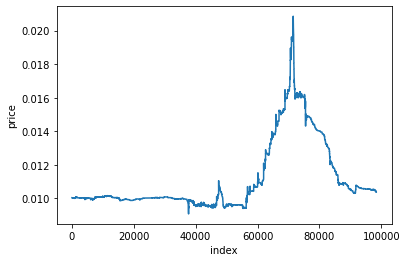

In [ ]:
fig, ax = plt.subplots()
# Add the time-series for 'mid' to the plot
ax.plot(df.index, df['mid']);
# Set the axis labels
ax.set_xlabel('index');
ax.set_ylabel('price');

Ah, truly representative of small-cap crypto charts. From the look of the enormous spike, I'd guess that simply providing liquidity on it might not be a profitable venture.

In [ ]:
df1 = df[['side','price', 'mid']]
df1['forward_mid'] = df1['mid'].shift(-1)
df1 = df1.dropna()
df1['pnl'] = np.where(df1['side'] == 'buy', df1['forward_mid'] - df1['price'], df1['price'] - df1['forward_mid'])

<ipython-input-7-ba85c96909d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['forward_mid'] = df1['mid'].shift(-1)


In [ ]:
df1['pnl'].describe()

count    9.339000e+04
mean    -2.897650e-06
std      3.929549e-05
min     -2.357500e-03
25%     -5.000000e-07
50%      0.000000e+00
75%      5.000000e-07
max      1.098500e-03
Name: pnl, dtype: float64

Well at least that confirms the first statement, simply buying the bid or selling the offer isn't profitable by itself with half of the spread. The result is negative mean and nasty negative skew. This is before handling of inventory and fees. Let's see how this differs with the highly unrealistic assumption of collecting every trade. Also, the reverse logic is that it is positive mean and positive skew to take the orders....

In [ ]:
df2 = df[['side','price', 'mid']]
df2['forward_mid'] = df2['mid'].shift(-1)
df2 = df2.dropna()
df2['pnl'] = np.where(df2['side'] == 'buy', df2['price'] - df2['forward_mid'], df2['forward_mid'] - df2['price'])

<ipython-input-9-940def3abe8b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['forward_mid'] = df2['mid'].shift(-1)


In [ ]:
df2['pnl'].describe()

count    9.339000e+04
mean     2.897650e-06
std      3.929549e-05
min     -1.098500e-03
25%     -5.000000e-07
50%      0.000000e+00
75%      5.000000e-07
max      2.357500e-03
Name: pnl, dtype: float64

As can be seen from [Hummingbot Backtest notebook](https://mybinder.org/v2/gh/crypto-lake/analysis-sharing/main?filepath=hummingbot_backtest.ipynb) on the same pair, the bulk of the volume is in 30 bps spread and below which is net unprofitable. And profit is realized from mid-price 1000 trades ahead. This means inventory management and great execution is required for successful market making operation even on a not hugely popular pair like this.   

## Spread Factors

From the same [Hummingbot Backtest notebook](https://mybinder.org/v2/gh/crypto-lake/analysis-sharing/main?filepath=hummingbot_backtest.ipynb) the pair was profitable from 40 bps spread onwards. Wouldn't it be great to learn the behaviour of these spreads. Returns are notoriously difficult to forecast, we know that volatility is less difficult to forecast, same for volume, but what about spread?

### Spread

I'll be looking at seasonality after so I resample the data to 5min. Since we now have spread data at reasonable frequency let's take a look.

In [ ]:
df3 = l1[['bid_0_price', 'ask_0_price']]
df3 = df3.rename(columns = {'bid_0_price': 'bid', 'ask_0_price': 'ask'})
df3['datetime'] = pd.to_datetime(l1['received_time'])
df3 = df3.set_index('datetime')
df4 = df3.resample('5min').first()
df4 = df4.dropna()
df4['minute'] = df4.index.minute
df4['hour'] = df4.index.hour
df4['spread'] = round((df4['ask'] - df4['bid']) / ((df4['ask'] + df4['bid']) / 2) * 10000)
df4

,bid,ask,minute,hour,spread
datetime,,,,,
2022-09-01 14:25:00,0.010029,0.010033,25,14,4.0
2022-09-01 14:30:00,0.010029,0.010033,30,14,4.0
2022-09-01 14:50:00,0.010029,0.010033,50,14,4.0
2022-09-01 15:55:00,0.010028,0.010033,55,15,5.0
2022-09-01 16:00:00,0.010013,0.010020,0,16,7.0
...,...,...,...,...,...
2022-11-19 22:20:00,0.010365,0.010367,20,22,2.0
2022-11-19 22:25:00,0.010363,0.010367,25,22,4.0
2022-11-19 22:30:00,0.010360,0.010363,30,22,3.0


In [ ]:
df4['spread'].describe()

count    10878.000000
mean         9.785806
std         10.409175
min          1.000000
25%          4.000000
50%          6.000000
75%         11.000000
max        193.000000
Name: spread, dtype: float64

From the 5min data resample. The mean spread is around 10 bps and the median spread is just 6 bps. Knowing that market making for this pair is only above 40 bps, it's notable that even the 75th percentile is just 12 bps. Let's do a count of rows above 40 bps. That's only 3% of the time.

In [ ]:
len(df4[df4['spread']>=40]) / len(df4['spread']) * 100

2.9601029601029603

This means that it's not a good businss case to market make on this pair for collecting the spread. But who are all these makers anyways, surely they're not giving away liquidity for charity? Even more friction is AscendEx charges maker fees for most tiers aside from the biggest whales. Turns out that FTRB is a pair that yields a lot in liquidity mining. [2.5% per day in yields as of Dec 6th, 2022](https://miner.hummingbot.io/).

So for those interested in taking in yields should take research into how to maximise those yields while trying to minimize costs of providing liquidity. Directional traders now find a pair that is positive to take liquidity should research into what drives returns.

Also notable that this is evidence there's a well capitalized market maker that's paying all the trading fees and eating all the toxic flow. Probably a first party affiliated MM bot. Third party market makers should quote outside of the danger zone as they're not compensated for the risk.

We're probably witnessing how Alameda ran an MM operation. With unnaturally tight spread first party market maker clearly can't make money from providing liquidity so their profit must come from somewhere else.

Sorry for the detour. But trading as a business we need to be upfront in what's our business case is. Meanwhile, learning about markets open up opportunities in the future.

### Seasonality

This is a factor that I often look at first. It's not always persistent but there's some basis for it in the real world as this is an asset that trades 24/7. We'll look at parts of the hour and zoom back out. I choose to skip day of the week analysis since we don't have much data.

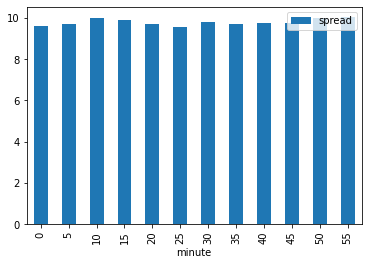

In [ ]:
df4.groupby('minute')['spread'].mean().plot(kind='bar', legend=True)

There's nothing to speak off here, it looks like there's some general rise from 30 min mark up to the end of the hour then lowers. But not to the point where it makes economical use anyways. Every 5-minute interval the spread is tight. It does seem to a little "artificial" though.

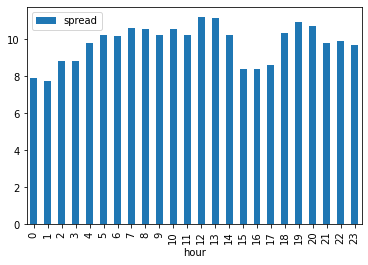

In [ ]:
df4.groupby('hour')['spread'].mean().plot(kind='bar', legend=True)

I've done research into other crypto data and found UTC 12 to be a notable time. Over here we see that the spread is highest there on average. Rising from 0 UTC. Probably a lot of trading programs go off around that time, providing liquidity and shrinking the spread. UTC 12 around the time that US Eastern Time wakes up the day.

### Bid/Ask Ratio

This is what I've been most interested in looking at. My hunch was that if the top of the book is more bid than ask then with less friction on the upside, positive return might be likely. More buying, thing goes up. Common sense right?

Well, now that we have data let's verify if this is actually supported by data.

In [ ]:
df5 = l1[['bid_0_price', 'ask_0_price', 'bid_0_size', 'ask_0_size']]
df5['datetime'] = pd.to_datetime(l1['received_time'])
df5['mid_price'] = (df5['bid_0_price'] + df5['ask_0_price']) / 2
df5 = df5.set_index('datetime')
df5 = df5.resample('5min').first()
df5 = df5.dropna()
df5['spread'] = round((df5['ask_0_price'] - df5['bid_0_price']) / ((df5['ask_0_price'] + df5['bid_0_price']) / 2) * 10000)
df5['log_returns'] = np.log(df5['mid_price'] / df5['mid_price'].shift(1))
df5 = df5.dropna()
df5['ratio'] = round(df5['bid_0_size'] / df5['ask_0_size'], 1)
df5['ratio'].describe()

count    10877.000000
mean         8.250722
std         73.751122
min          0.000000
25%          0.300000
50%          1.100000
75%          5.000000
max       7135.200000
Name: ratio, dtype: float64

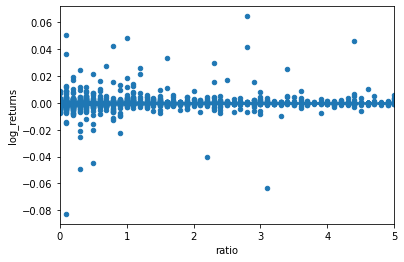

In [ ]:
df5.plot.scatter(x = 'ratio', y = 'log_returns', xlim = (0,5))

I've removed the insane bullish outliers since 75th percentile is just 5. Well it's looking pretty flat to me. Maybe there's more information with L2 data. At least for one pair I see that the very top of book doesn't contain all that much information and I don't have to fixate on it so much.

## Wrapping Up

Well I've learned a few things, such as get clear on what's the sort of trades I want to be paid on. I get some more experience at using Pandas for data analysis. No effect jumped out at me other than incentives and liquidity mining rewards will have concrete effects on how an instrument trades, especially for smaller ones.

## What's Next?

I'll be looking BTC's data. Since it's the Big Boy of Cryptoland, there's probably interesting effects to be found. Don't expect much inefficiency on one of the most 